In [1]:
# encoding:utf-8
class ConfigX(object):
    """
    docstring for ConfigX

    configurate the global parameters and hyper parameters

    """

    def __init__(self):
        super(ConfigX, self).__init__()

        # Dataset Parameters
        self.dataset_name = "CiaoDVD"  # short name of datasets ["ft":"filmtrust","db":"douban","ca":"ciao"]
        self.k_fold_num = 5  # the num of cross validation
        self.rating_path = "/content/drive/MyDrive/data/ft_ratings.txt"  # the raw ratings data file
        self.rating_cv_path = "../data/cv/"  # the cross validation file of ratings data
        self.trust_path = '/content/drive/MyDrive/data/ft_trust_SimRank.txt'   # the raw trust data file
        self.sep = ' '  # the separator of rating and trust data in triple tuple
        self.random_state = 0  # the seed of random number
        self.size = 0.6  # the ratio of train set
        self.min_val = 0.5  # the minimum rating value
        self.max_val = 4.0  # the maximum rating value

        # Model HyperParameter
        self.coldUserRating = 5  # the number of ratings a cold start user rated on items
        self.factor = 10  # the size of latent dimension for user and item.
        self.threshold = 1e-4  # the threshold value of model training 
        self.lr = 0.01  # the learning rate
        self.maxIter = 100  # the maximum number of iterations
        self.lambdaP = 0.001  # the parameter of user regularizer
        self.lambdaQ = 0.001  # the parameter of item regularizer
        self.gamma = 0  # momentum coefficient
        self.isEarlyStopping = False  # early stopping flag

        # Output Parameters
        self.result_path = "../results/"  # the directory of results
        self.model_path = "model/"  # the directory of well-trained variables
        self.result_log_path = "log/"  # the directory of logs when training models


In [2]:
# encoding:utf-8
import sys

sys.path.append("..")
import os
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
#from configx.configx import ConfigX

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Split ratings into five folds
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


def split_5_folds(configx):
    K = configx.k_fold_num
    names = ['user_id', 'item_id', 'rating']
    if not os.path.isfile(configx.rating_path):
        print("the format of rating data is wrong")
        sys.exit()
    df = pd.read_csv(configx.rating_path, sep=configx.sep, names=names)
    ratings = coo_matrix((df.rating, (df.user_id, df.item_id)))
    users = np.unique(ratings.row)
    ratings = ratings.tocsr()

    rows = list()
    cols = list()
    vals = list()
    nonzeros = list()

    for k in range(K):
        size_of_bucket = int(ratings.nnz / K)
        if k == K - 1:
            size_of_bucket += ratings.nnz % K
        rows.append(np.zeros(size_of_bucket))
        cols.append(np.zeros(size_of_bucket))
        vals.append(np.zeros(size_of_bucket))
        nonzeros.append(0)

    for i, user in enumerate(users):
        items = ratings[user, :].indices
        rating_vals = ratings[user, :].data
        index_list = [i for i in range(K)] * int(len(items) / float(K) + 1)
        np.random.shuffle(index_list)
        index_list = np.array(index_list)

        for k in range(K):
            k_index_list = (index_list[:len(items)] == k)
            from_ind = nonzeros[k]
            to_ind = nonzeros[k] + sum(k_index_list)

            if to_ind >= len(rows[k]):
                rows[k] = np.append(rows[k], np.zeros(size_of_bucket))
                cols[k] = np.append(cols[k], np.zeros(size_of_bucket))
                vals[k] = np.append(vals[k], np.zeros(size_of_bucket))
                k_index_list = (index_list[:len(items)] == k)

            rows[k][from_ind:to_ind] = [user] * sum(k_index_list)
            cols[k][from_ind:to_ind] = items[k_index_list]
            vals[k][from_ind:to_ind] = rating_vals[k_index_list]
            nonzeros[k] += sum(k_index_list)

    if not os.path.exists('../data/cv'):
        os.makedirs('../data/cv')
        print('../data/cv folder has been established.')

    for k, (row, col, val, nonzero) in enumerate(zip(rows, cols, vals, nonzeros)):
        bucket_df = pd.DataFrame({'user': row[:nonzero], 'item': col[:nonzero], 'rating': val[:nonzero]},
                                 columns=['user', 'item', 'rating'])
        bucket_df.to_csv("../data/cv/%s-%d.csv" % (configx.dataset_name, k), sep=configx.sep, header=False, index=False)
        print("%s -fold%d data generated finished!" % (configx.dataset_name, k))

    print("All Data Generated Done!")


if __name__ == "__main__":
    configx = ConfigX()
    split_5_folds(configx)


../data/cv folder has been established.
CiaoDVD -fold0 data generated finished!
CiaoDVD -fold1 data generated finished!
CiaoDVD -fold2 data generated finished!
CiaoDVD -fold3 data generated finished!
CiaoDVD -fold4 data generated finished!
All Data Generated Done!


In [3]:
# encoding:utf-8
import sys

sys.path.append("..")
import pandas as pd
#from configx.configx import ConfigX

config = ConfigX()
data = pd.read_table(config.trust_path, sep=' ', header=None)
# the number of links
print(len(data))

# the number of followers
print(len(data[0].unique()))

# the number of followees
print(len(data[1].unique()))


2494
824
732


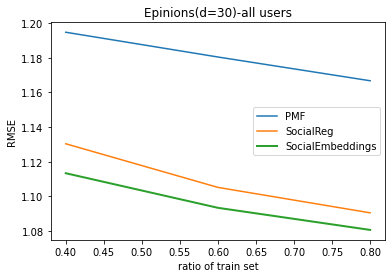

In [4]:
import matplotlib.pylab as plt


def show_rmse():
    '''
    show figure
    '''

    # epinions
    mfr = [1.16677, 1.18048, 1.19479]
    sr = [1.09047, 1.10516, 1.13036]
    my = [1.08060, 1.09336, 1.11335]
    x = [0.8, 0.6, 0.4]

    plt.plot(x, mfr, label='PMF')
    plt.plot(x, sr, label='SocialReg')
    plt.plot(x, my, linewidth='2', label='SocialEmbeddings')

    plt.xlabel('ratio of train set')
    plt.ylabel('RMSE')
    plt.title('Epinions(d=30)-all users')
    plt.legend()
    plt.show()
    pass


show_rmse()


In [5]:
class SimMatrix(object):
    def __init__(self):
        self.symMatrix = {}

    def __getitem__(self, item):
        if item in self.symMatrix:
            return self.symMatrix[item]
        return {}

    def set(self, i, j, val):
        if not i in self.symMatrix:
            self.symMatrix[i] = {}
        self.symMatrix[i][j] = val
        if not j in self.symMatrix:
            self.symMatrix[j] = {}
        self.symMatrix[j][i] = val

    def get(self, i, j):
        if not i in self.symMatrix or not j in self.symMatrix[i]:
            return 0
        return self.symMatrix[i][j]

    def contains(self, i, j):
        if i in self.symMatrix and j in self.symMatrix[i]:
            return True
        else:
            return False


In [6]:
# encoding:utf-8
import sys

sys.path.append("..")

import numpy as np
from numpy.linalg import norm
#from configx.configx import ConfigX

config = ConfigX()


def l1(x):
    return norm(x, ord=1)


def l2(x):
    return norm(x)


def normalize(rating, minVal=config.min_val, maxVal=config.max_val):
    'get the normalized value using min-max normalization'
    if maxVal > minVal:
        return float(rating - minVal) / (maxVal - minVal) + 0.01
    elif maxVal == minVal:
        return rating / maxVal
    else:
        print('error... maximum value is less than minimum value.')
        raise ArithmeticError


def denormalize(rating, minVal=config.min_val, maxVal=config.max_val):
    return minVal + (rating - 0.01) * (maxVal - minVal)


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


def sigmoid_deriv(z):
    return sigmoid(z) * (1.0 - sigmoid(z))


def sigmoid_2(z):
    return 1.0 / (1.0 + np.exp(-z / 2.0))


In [7]:
# encoding:utf-8
import sys

sys.path.append("..")

import pickle


def save_data(obj, filename):
    pickle.dump(obj, open(filename, 'wb'))
    pass


def load_data(filename):
    f = open(filename, 'rb')
    model = pickle.load(f)
    print(filename + ' load data model finished.')
    return model


In [8]:
# encoding:utf-8
import math


class Metric(object):
    '''
    the two metrics to measure the prediction accuracy for rating prediction task
    '''

    def __init__(self):
        pass

    @staticmethod
    def MAE(res):
        error = 0
        count = 0
        for entry in res:
            error += abs(entry[2] - entry[3])
            count += 1
        if count == 0:
            return error
        return float(error) / count

    @staticmethod
    def RMSE(res):
        error = 0
        count = 0
        for entry in res:
            error += abs(entry[2] - entry[3]) ** 2
            count += 1
        if count == 0:
            return error
        return math.sqrt(float(error) / count)


In [9]:
# encoding:utf-8
import sys

sys.path.append("..")
import os
from collections import defaultdict
import numpy as np

#from utility.tools import normalize
#from configx.configx import ConfigX


class RatingGetter(object):
    """
    docstring for RatingGetter
    read rating data and save the global parameters
    """

    def __init__(self, k):
        super(RatingGetter, self).__init__()
        self.config = ConfigX()
        self.k_current = k
        self.user = {}
        self.item = {}
        self.all_User = {}
        self.all_Item = {}
        self.id2user = {}
        self.id2item = {}
        self.dataSet_u = defaultdict(dict)
        self.trainSet_u = defaultdict(dict)
        self.trainSet_i = defaultdict(dict)
        self.testSet_u = defaultdict(dict)  # used to store the test set by hierarchy user:[item,rating]
        self.testSet_i = defaultdict(dict)  # used to store the test set by hierarchy item:[user,rating]
        self.testColdUserSet_u = defaultdict(dict)  # cold start users in test set
        self.trainHotUserSet = []  # hot users in train set
        self.trainSetLength = 0
        self.testSetLength = 0

        self.userMeans = {}  # used to store the mean values of users's ratings
        self.itemMeans = {}  # used to store the mean values of items's ratings
        self.globalMean = 0

        self.generate_data_set()  # generate train and test set
        self.getDataSet()
        self.get_data_statistics()
        self.get_cold_start_users()

    def generate_data_set(self):
        for index, line in enumerate(self.trainSet()):
            u, i, r = line
            # print(u,i,r)
            if not u in self.user:
                self.user[u] = len(self.user)
                self.id2user[self.user[u]] = u
            if not i in self.item:
                self.item[i] = len(self.item)
                self.id2item[self.item[i]] = i

            self.trainSet_u[u][i] = r
            self.trainSet_i[i][u] = r
            self.trainSetLength = index + 1
        self.all_User.update(self.user)
        self.all_Item.update(self.item)

        for index, line in enumerate(self.testSet()):
            u, i, r = line
            if not u in self.user:
                self.all_User[u] = len(self.all_User)
            if not i in self.item:
                self.all_Item[i] = len(self.all_Item)
            self.testSet_u[u][i] = r
            self.testSet_i[i][u] = r
            self.testSetLength = index + 1
        # print(self.trainSetLength)
        # print(self.testSetLength)
        pass

    # for cross validation
    def trainSet(self):
        k = self.k_current
        for i in range(self.config.k_fold_num):
            if i != k:
                data_path = self.config.rating_cv_path + self.config.dataset_name + "-" + str(i) + ".csv"
                # if not os.path.exists
                if not os.path.isfile(data_path):
                    print("the format of ratings data is wrong!")
                    sys.exit()
                with open(data_path, 'r') as f:
                    for index, line in enumerate(f):
                        u, i, r = line.strip('\r\n').split(self.config.sep)
                        r = normalize(float(r))  # scale the rating score to [0-1]
                        yield (int(float(u)), int(float(i)), float(r))

    def testSet(self):
        k = self.k_current
        data_path = self.config.rating_cv_path + self.config.dataset_name + "-" + str(k) + ".csv"
        if not os.path.isfile(data_path):
            print("the format of ratings data is wrong!")
            sys.exit()
        with open(data_path, 'r') as f:
            for index, line in enumerate(f):
                u, i, r = line.strip('\r\n').split(self.config.sep)
                yield (int(float(u)), int(float(i)), float(r))

    # for random
    # def trainSet(self):
    #     np.random.seed(self.config.random_state)
    #     with open(self.config.rating_path,'r') as f:
    #         for index,line in enumerate(f):
    #             rand_num=np.random.rand()
    #             if  rand_num < self.config.size:
    #                 u,i,r=line.strip('\r\n').split(self.config.sep)
    #                 r=normalize(float(r)) #scale the rating score to [0-1]
    #                 yield (int(u),int(i),float(r))

    # def testSet(self):
    #     np.random.seed(self.config.random_state)
    #     with open(self.config.rating_path,'r') as f:
    #         for index,line in enumerate(f):
    #             rand_num=np.random.rand()
    #             if  rand_num >= self.config.size:
    #                 u,i,r=line.strip('\r\n').split(self.config.sep)
    #                 yield (int(u),int(i),float(r))

    def getDataSet(self):
        with open(self.config.rating_path, 'r') as f:
            for index, line in enumerate(f):
                u, i, r = line.strip('\r\n').split(self.config.sep)
                self.dataSet_u[int(u)][int(i)] = float(r)

    def get_train_size(self):
        return (len(self.user), len(self.item))

    # get cold start users in test set
    def get_cold_start_users(self):
        for user in self.testSet_u.keys():
            rating_length = len(self.trainSet_u[user])
            if rating_length <= self.config.coldUserRating:
                self.testColdUserSet_u[user] = self.testSet_u[user]
        # print('cold start users count', len(self.testColdUserSet_u))

    def get_data_statistics(self):

        total_rating = 0.0
        total_length = 0
        for u in self.user:
            u_total = sum(self.trainSet_u[u].values())
            u_length = len(self.trainSet_u[u])
            total_rating += u_total
            total_length += u_length
            self.userMeans[u] = u_total / float(u_length)

        for i in self.item:
            self.itemMeans[i] = sum(self.trainSet_i[i].values()) / float(len(self.trainSet_i[i]))

        if total_length == 0:
            self.globalMean = 0
        else:
            self.globalMean = total_rating / total_length

    def containsUser(self, u):
        'whether user is in training set'
        if u in self.user:
            return True
        else:
            return False

    def containsItem(self, i):
        'whether item is in training set'
        if i in self.item:
            return True
        else:
            return False

    def containsUserItem(self, user, item):
        if user in self.trainSet_u:
            if item in self.trainSet_u[user]:
                # print(user)
                # print(item)
                # print(self.trainSet_u[user][item])
                return True
        return False

    def get_row(self, u):
        return self.trainSet_u[u]

    def get_col(self, c):
        return self.trainSet_i[c]

    def user_rated_items(self, u):
        return self.trainSet_u[u].keys()


if __name__ == '__main__':
    rg = RatingGetter(0)
    # for ind,entry in enumerate(rg.testSet()):
    # 	if ind<80:
    # 		print(entry)
    # # 		user,item,rating = entry

    # print(rg.trainSet_u[52])
    # print(rg.trainSet_u[10])


In [10]:
# encoding:utf-8
import sys

sys.path.append("..")
import numpy as np
from math import sqrt
#from utility.tools import sigmoid_2


# x1,x2 is the form of np.array.

def euclidean(x1, x2):
    # find common ratings
    new_x1, new_x2 = common(x1, x2)
    # compute the euclidean between two vectors
    diff = new_x1 - new_x2
    denom = sqrt((diff.dot(diff)))
    try:
        return 1 / denom
    except ZeroDivisionError:
        return 0


def cosine(x1, x2):
    # find common ratings
    new_x1, new_x2 = common(x1, x2)
    # compute the cosine similarity between two vectors
    sum = new_x1.dot(new_x2)
    denom = sqrt(new_x1.dot(new_x1) * new_x2.dot(new_x2))
    try:
        return float(sum) / denom
    except ZeroDivisionError:
        return 0


def pearson(x1, x2):
    # find common ratings
    new_x1, new_x2 = common(x1, x2)
    # compute the pearson similarity between two vectors
    ind1 = new_x1 > 0
    ind2 = new_x2 > 0
    try:
        mean_x1 = float(new_x1.sum()) / ind1.sum()
        mean_x2 = float(new_x2.sum()) / ind2.sum()
        new_x1 = new_x1 - mean_x1
        new_x2 = new_x2 - mean_x2
        sum = new_x1.dot(new_x2)
        denom = sqrt((new_x1.dot(new_x1)) * (new_x2.dot(new_x2)))
        return float(sum) / denom
    except ZeroDivisionError:
        return 0


def common(x1, x2):
    # find common ratings
    common = (x1 != 0) & (x2 != 0)
    new_x1 = x1[common]
    new_x2 = x2[common]
    return new_x1, new_x2


# x1,x2 is the form of dict.

def cosine_sp(x1, x2):
    'x1,x2 are dicts,this version is for sparse representation'
    total = 0
    denom1 = 0
    denom2 = 0
    # x1_l,x2_l=len(x1),len(x2)
    # if x2_l>x1_l:
    # x1,x2=x2,x1
    for k in x1:
        if k in x2:
            total += x1[k] * x2[k]
            denom1 += x1[k] ** 2
            denom2 += x2[k] ** 2  # .pop(k)
        # else:
        # denom1+=x1[k]**2
    # for j in x2:
    # 	denom2+=x2[j]**2
    try:
        return (total + 0.0) / (sqrt(denom1) * sqrt(denom2))
    except ZeroDivisionError:
        return 0


def cosine_improved_sp(x1, x2):
    'x1,x2 are dicts,this version is for sparse representation'
    total = 0
    denom1 = 0
    denom2 = 0
    nu = 0
    for k in x1:
        if k in x2:
            nu += 1
            total += x1[k] * x2[k]
            denom1 += x1[k] ** 2
            denom2 += x2[k] ** 2
    try:
        return (total + 0.0) / (sqrt(denom1) * sqrt(denom2)) * sigmoid_2(nu)
    except ZeroDivisionError:
        return 0


# def pearson_sp(x1, x2):
#     total = 0
#     denom1 = 0
#     denom2 = 0
#     try:
#         mean1 = sum(x1.values()) / (len(x1) + 0.0)
#         mean2 = sum(x2.values()) / (len(x2) + 0.0)
#         for k in x1:
#             if k in x2:
#                 total += (x1[k] - mean1) * (x2[k] - mean2)
#                 denom1 += (x1[k] - mean1) ** 2
#                 denom2 += (x2[k] - mean2) ** 2
#         return (total + 0.0) / (sqrt(denom1) * sqrt(denom2))
#     except ZeroDivisionError:
#         return 0

# improved pearson
def pearson_sp(x1, x2):
    common = set(x1.keys()) & set(x2.keys())
    if len(common) == 0:
        return 0
    ratingList1 = []
    ratingList2 = []
    for i in common:
        ratingList1.append(x1[i])
        ratingList2.append(x2[i])
    if len(ratingList1) == 0 or len(ratingList2) == 0:
        return 0
    avg1 = sum(ratingList1) / len(ratingList1)
    avg2 = sum(ratingList2) / len(ratingList2)
    mult = 0.0
    sum1 = 0.0
    sum2 = 0.0
    for i in range(len(ratingList1)):
        mult += (ratingList1[i] - avg1) * (ratingList2[i] - avg2)
        sum1 += pow(ratingList1[i] - avg1, 2)
        sum2 += pow(ratingList2[i] - avg2, 2)
    if sum1 == 0 or sum2 == 0:
        return 0
    return mult / (sqrt(sum1) * sqrt(sum2))


# TrustWalker userd
def pearson_improved_sp(x1, x2):
    total = 0.0
    denom1 = 0
    denom2 = 0
    nu = 0
    try:
        mean1 = sum(x1.values()) / (len(x1) + 0.0)
        mean2 = sum(x2.values()) / (len(x2) + 0.0)
        for k in x1:
            if k in x2:
                # print('k'+str(k))
                nu += 1
                total += (x1[k] - mean1) * (x2[k] - mean2)
                # print('t'+str(total))
                denom1 += (x1[k] - mean1) ** 2
                denom2 += (x2[k] - mean2) ** 2
        # print('nu:'+str(nu))
        # print(total)
        return (total + 0.0) / (sqrt(denom1) * sqrt(denom2)) * sigmoid_2(nu)
    except ZeroDivisionError:
        return 0


def euclidean_sp(x1, x2):
    total = 0.0
    for k in x1:
        if k in x2:
            total += sqrt(x1[k] - x2[k])
    try:
        return 1.0 / total
    except ZeroDivisionError:
        return 0


In [13]:
# encoding:utf-8
import sys

sys.path.append("..")

#from metrics.metric import Metric
#from utility.tools import denormalize, sigmoid
#from reader.rating import RatingGetter
#from reader.trust import TrustGetter
#from configx.configx import ConfigX


class DataStatis(object):
    """docstring for DataStatis"""

    def __init__(self):
        super(DataStatis, self).__init__()
        self.config = ConfigX()
        self.rg = RatingGetter(0)  # loading rating data
        self.tg = TrustGetter()     
        self.cold_rating = 0
        self.cold_social = 0
        self.cold_rating_social = 0
        self.cold_rating_warm_social = 0
        self.warm_rating_cold_social = 0
        self.warm_rating_warm_social = 0

    def getDataStatis(self):
        # print(self.rg.dataSet_u[2])
        for user in self.rg.dataSet_u:
            # print(user)
            num_rating = len(self.rg.dataSet_u[user])
            num_social = len(self.tg.followees[user])

            if (num_rating < 5):
                self.cold_rating += 1
            if (num_social < 5):
                self.cold_social += 1

            if (num_rating < 5 and num_social < 5):
                self.cold_rating_social += 1
            if (num_rating < 5 and num_social >= 5):
                self.cold_rating_warm_social += 1
            if (num_rating >= 5 and num_social <= 5):
                self.warm_rating_cold_social += 1
            if (num_rating >= 5 and num_social >= 5):
                self.warm_rating_warm_social += 1

        pass


if __name__ == '__main__':
    ds = DataStatis()
    ds.getDataStatis()
    print(ds.cold_rating)
    print(ds.cold_social)
    print(ds.cold_rating_social)
    print(ds.cold_rating_warm_social)
    print(ds.warm_rating_cold_social)
    print(ds.warm_rating_warm_social)


15006
17486
14948
58
2554
71


In [12]:
# encoding:utf-8
import sys

sys.path.append("..")
import numpy as np
import os
from collections import defaultdict

#from configx.configx import ConfigX


class TrustGetter(object):
    """
    docstring for TrustGetter
    read trust data and save the global parameters

    """

    def __init__(self):
        super(TrustGetter, self).__init__()
        self.config = ConfigX()

        self.user = {}  # used to store the order of users
        self.relations = self.get_relations()
        self.followees = defaultdict(dict)
        self.followers = {}
        self.matrix_User = {}
        self.matrix_Item = {}
        self.generate_data_set()

    def generate_data_set(self):
        triple = []
        for line in self.relations:
            userId1, userId2, weight = line
            # add relations to dict
            if not userId1 in self.followees:
                self.followees[userId1] = {}
            self.followees[userId1][userId2] = weight
            if not userId2 in self.followers:
                self.followers[userId2] = {}
            self.followers[userId2][userId1] = weight
            # order the user
            if not userId1 in self.user:
                userid1 = self.user[userId1] = len(self.user)
            if not userId2 in self.user:
                userid2 = self.user[userId2] = len(self.user)
            if not userid1 in self.matrix_User:
                self.matrix_User[userid1] = {}
            if not userid2 in self.matrix_User:
                self.matrix_Item[userid2] = {}
            self.matrix_User[userid1][userid2] = weight
            self.matrix_Item[userid2][userid1] = weight

    def get_relations(self):
        if not os.path.isfile(self.config.trust_path):
            print("the format of trust data is wrong")
            sys.exit()
        with open(self.config.trust_path, 'r') as f:
            for index, line in enumerate(f):
                u_from, u_to, t = line.strip('\r\n').split(self.config.sep)
                yield (int(u_from), int(u_to), float(t))

    def get_followees(self, u):
        if u in self.followees:
            return self.followees[u]
        else:
            return {}

    def get_followers(self, u):
        if u in self.followers:
            return self.followers[u]
        else:
            return {}

    def weight(self, u, k):
        if u in self.followees and k in self.followees[u]:
            return self.followees[u][k]
        else:
            return 0


if __name__ == '__main__':
    tg = TrustGetter()
    s = tg.get_followees(2).keys()
    print(s)


dict_keys([966, 104, 1567])


In [14]:
#encoding:utf-8
import  sys
sys.path.append("..")

import numpy as np
import matplotlib.pylab as plt

#from prettyprinter import cpprint
#from metrics.metric import Metric
#from utility.tools import denormalize,sigmoid
#from reader.rating import RatingGetter
##from configx.configx import ConfigX


class MF(object):
    """
    docstring for MF
    the base class for matrix factorization based model-parent class

    """

    def __init__(self):
        super(MF, self).__init__()
        self.config = ConfigX()
        print(self.config.__dict__)  #print the configuration

        # self.rg = RatingGetter()  # loading raing data
        # self.init_model()
        self.iter_rmse = []
        self.iter_mae = []
        pass

    def init_model(self,k):
        self.read_data(k)
        self.P = np.random.rand(self.rg.get_train_size()[0], self.config.factor) / (
        self.config.factor ** 0.5)  # latent user matrix
        self.Q = np.random.rand(self.rg.get_train_size()[1], self.config.factor) / (
        self.config.factor ** 0.5)  # latent item matrix
        self.loss, self.lastLoss = 0.0, 0.0
        self.lastRmse, self.lastMae = 10.0,10.0
        pass

    def read_data(self,k):
        self.rg = RatingGetter(k)
        pass

    def train_model(self,k):
        self.init_model(k)
        pass

    # test all users in test set
    def predict_model(self):
        res = []
        for ind, entry in enumerate(self.rg.testSet()):
            user, item, rating = entry
            rating_length = len(self.rg.trainSet_u[user]) # remove cold start users for test
            if rating_length <= self.config.coldUserRating:
                continue

            prediction = self.predict(user, item)
            # denormalize
            prediction = denormalize(prediction, self.config.min_val, self.config.max_val)

            pred = self.checkRatingBoundary(prediction)
            # add prediction in order to measure
            res.append([user, item, rating, pred])
        rmse = Metric.RMSE(res)
        mae = Metric.MAE(res)
        self.iter_rmse.append(rmse)  # for plot
        self.iter_mae.append(mae)
        return rmse, mae

    # test cold start users among test set
    def predict_model_cold_users(self):
        res = []
        for user in self.rg.testColdUserSet_u.keys():
            for item in self.rg.testColdUserSet_u[user].keys():
                rating = self.rg.testColdUserSet_u[user][item]
                pred = self.predict(user, item)
                # pred = sigmoid(pred)
                # denormalize
                pred = denormalize(pred, self.config.min_val, self.config.max_val)
                pred = self.checkRatingBoundary(pred)
                res.append([user, item, rating, pred])
        rmse = Metric.RMSE(res)
        mae = Metric.MAE(res)
        return rmse,mae

    def predict(self, u, i):
        if self.rg.containsUser(u) and self.rg.containsItem(i):
            return self.P[self.rg.user[u]].dot(self.Q[self.rg.item[i]])
        elif self.rg.containsUser(u) and not self.rg.containsItem(i):
            return self.rg.userMeans[u]
        elif not self.rg.containsUser(u) and self.rg.containsItem(i):
            return self.rg.itemMeans[i]
        else:
            return self.rg.globalMean

    def checkRatingBoundary(self, prediction):
        prediction =round( min( max( prediction , self.config.min_val ) , self.config.max_val ) ,3)
        return prediction

    def isConverged(self, iter):
        from math import isnan
        if isnan(self.loss):
            print(
                'Loss = NaN or Infinity: current settings does not fit the recommender! Change the settings and try again!')
            exit(-1)

        deltaLoss = (self.lastLoss - self.loss)
        rmse, mae = self.predict_model()

        # early stopping
        if self.config.isEarlyStopping == True:
            cond = self.lastRmse < rmse
            if cond:
                print('test rmse increase, so early stopping')
                return cond
            self.lastRmse = rmse
            self.lastMae = mae

        print('%s iteration %d: loss = %.4f, delta_loss = %.5f learning_Rate = %.5f rmse=%.5f mae=%.5f' % \
              (self.__class__, iter, self.loss, deltaLoss, self.config.lr, rmse, mae))

        # check if converged
        cond = abs(deltaLoss) < self.config.threshold
        converged = cond
        # if not converged:
        # 	self.updateLearningRate(iter)
        self.lastLoss = self.loss
        # shuffle(self.dao.trainingData)
        return converged

    def updateLearningRate(self, iter):
        if iter > 1:
            if abs(self.lastLoss) > abs(self.loss):
                self.config.lr *= 1.05
            else:
                self.config.lr *= 0.5
        if self.config.lr > 1:
            self.config.lr = 1

    def show_rmse(self):
        '''
        show figure for rmse and epoch
        '''
        nums = range(len(self.iter_rmse))
        plt.plot(nums, self.iter_rmse, label='RMSE')
        plt.plot(nums, self.iter_mae, label='MAE')
        plt.xlabel('# of epoch')
        plt.ylabel('metric')
        plt.title(self.__class__)
        plt.legend()
        plt.show()
        pass
    def show_loss(self,loss_all,faloss_all):
        '''
        show figure for rmse and epoch
        '''
        nums = range(len(loss_all))
        plt.plot(nums, loss_all, label='front')
        plt.plot(nums, faloss_all, label='rear')
        plt.xlabel('# of epoch')
        plt.ylabel('loss')
        plt.title('loss experiment')
        plt.legend()
        plt.show()
        pass


In [15]:
# encoding:utf-8
import sys

sys.path.append("..")
#from prettyprinter import cpprint
import numpy as np
#from mf import MF


class SVDPP(MF):
    """
    docstring for SVDPP
    implement the SVDPP

    Koren Y. Factor in the neighbors: Scalable and accurate collaborative filtering[J]. ACM Transactions on Knowledge Discovery from Data (TKDD), 2010, 4(1): 1.
    """

    def __init__(self):
        super(SVDPP, self).__init__()
        self.config.lambdaP = 0.001
        self.config.lambdaQ = 0.001

        self.config.lambdaY = 0.001
        self.config.lambdaB = 0.001
        # self.init_model()

    def init_model(self, k):
        super(SVDPP, self).init_model(k)
        self.Bu = np.random.rand(self.rg.get_train_size()[0]) / (self.config.factor ** 0.5)  # bias value of user
        self.Bi = np.random.rand(self.rg.get_train_size()[1]) / (self.config.factor ** 0.5)  # bias value of item
        self.Y = np.random.rand(self.rg.get_train_size()[1], self.config.factor) / (
                self.config.factor ** 0.5)  # implicit preference
        self.SY = dict()

    def train_model(self, k):
        super(SVDPP, self).train_model(k)
        iteration = 0
        while iteration < self.config.maxIter:
            self.loss = 0
            for index, line in enumerate(self.rg.trainSet()):
                user, item, rating = line
                u = self.rg.user[user]
                i = self.rg.item[item]
                error = rating - self.predict(user, item)
                self.loss += error ** 2

                p, q = self.P[u], self.Q[i]
                nu, sum_y = self.get_sum_y(user)

                # update latent vectors
                self.P[u] += self.config.lr * (error * q - self.config.lambdaP * p)
                self.Q[i] += self.config.lr * (error * (p + sum_y) - self.config.lambdaQ * q)

                self.Bu[u] += self.config.lr * (error - self.config.lambdaB * self.Bu[u])
                self.Bi[i] += self.config.lr * (error - self.config.lambdaB * self.Bi[i])

                u_items = self.rg.user_rated_items(u)
                for j in u_items:
                    idj = self.rg.item[j]
                    self.Y[idj] += self.config.lr * (error / np.sqrt(nu) * q - self.config.lambdaY * self.Y[idj])

            self.loss += self.config.lambdaP * (self.P * self.P).sum() + self.config.lambdaQ * (self.Q * self.Q).sum() \
                         + self.config.lambdaB * (
                                 (self.Bu * self.Bu).sum() + (self.Bi * self.Bi).sum()) + self.config.lambdaY * (
                                     self.Y * self.Y).sum()
            iteration += 1
            if self.isConverged(iteration):
                break

    def predict(self, u, i):
        if self.rg.containsUser(u) and self.rg.containsItem(i):
            _, sum_y = self.get_sum_y(u)
            u = self.rg.user[u]
            i = self.rg.item[i]
            return self.Q[i].dot(self.P[u] + sum_y) + self.rg.globalMean + self.Bi[i] + self.Bu[u]
        else:
            return self.rg.globalMean

    def get_sum_y(self, u):
        if u in self.SY:
            return self.SY[u]
        u_items = self.rg.user_rated_items(u)
        nu = len(u_items)
        sum_y = np.zeros(self.config.factor)
        for j in u_items:
            sum_y += self.Y[self.rg.item[j]]
        sum_y /= (np.sqrt(nu))
        self.SY[u] = [nu, sum_y]
        return nu, sum_y


if __name__ == '__main__':
    rmses = []
    maes = []
    tcsr = SVDPP()
    # print(bmf.rg.trainSet_u[1])
    for i in range(tcsr.config.k_fold_num):
        print('the %dth cross validation training' % i)
        tcsr.train_model(i)
        rmse, mae = tcsr.predict_model()
        rmses.append(rmse)
        maes.append(mae)
    rmse_avg = sum(rmses) / 5
    mae_avg = sum(maes) / 5
    print("the rmses are %s" % rmses)
    print("the maes are %s" % maes)
    print("the average of rmses is %s " % rmse_avg)
    print("the average of maes is %s " % mae_avg)


{'dataset_name': 'CiaoDVD', 'k_fold_num': 5, 'rating_path': '/content/drive/MyDrive/data/ft_ratings.txt', 'rating_cv_path': '../data/cv/', 'trust_path': '/content/drive/MyDrive/data/ft_trust_SimRank.txt', 'sep': ' ', 'random_state': 0, 'size': 0.6, 'min_val': 0.5, 'max_val': 4.0, 'coldUserRating': 5, 'factor': 10, 'threshold': 0.0001, 'lr': 0.01, 'maxIter': 100, 'lambdaP': 0.001, 'lambdaQ': 0.001, 'gamma': 0, 'isEarlyStopping': False, 'result_path': '../results/', 'model_path': 'model/', 'result_log_path': 'log/'}
the 0th cross validation training
<class '__main__.SVDPP'> iteration 1: loss = 90633.5701, delta_loss = -90633.57014 learning_Rate = 0.01000 rmse=1.46818 mae=1.05344
<class '__main__.SVDPP'> iteration 2: loss = 28852.4464, delta_loss = 61781.12372 learning_Rate = 0.01000 rmse=1.38845 mae=1.01407
<class '__main__.SVDPP'> iteration 3: loss = 16036.4260, delta_loss = 12816.02043 learning_Rate = 0.01000 rmse=1.31854 mae=0.97584
<class '__main__.SVDPP'> iteration 4: loss = 12124.8

In [16]:
# encoding:utf-8
import sys

sys.path.append("..")
import numpy as np
#from mf import MF
#from reader.trust import TrustGetter


class SocialMF(MF):
    """
    docstring for SocialMF

    Jamali M, Ester M. A matrix factorization technique with trust propagation for recommendation in social networks[C]//Proceedings of the fourth ACM conference on Recommender systems. ACM, 2010: 135-142.
    """

    def __init__(self):
        super(SocialMF, self).__init__()
        # self.config.lr=0.0001
        self.config.alpha = 1  # 0.8 rmse=0.87605
        self.tg = TrustGetter()  # loading trust data
        # self.init_model()

    def train_model(self, k):
        super(SocialMF, self).train_model(k)
        iteration = 0
        while iteration < self.config.maxIter:
            self.loss = 0
            for index, line in enumerate(self.rg.trainSet()):
                user, item, rating = line
                u = self.rg.user[user]
                i = self.rg.item[item]
                error = rating - self.predict(user, item)
                self.loss += error ** 2
                p, q = self.P[u], self.Q[i]

                total_weight = 0.0
                social_term = np.zeros(self.config.factor)
                followees = self.tg.get_followees(user)  # get user u's focus lsit
                for followee in followees:
                    weight = followees[followee]
                    if self.rg.containsUser(followee):
                        uk = self.P[self.rg.user[followee]]
                        social_term += weight * uk
                        total_weight += weight

                if total_weight != 0:
                    social_term = p - social_term / total_weight

                social_term_a = np.zeros(self.config.factor)
                total_count = 0
                followers = self.tg.get_followers(user)
                for follower in followers:
                    if self.rg.containsUser(follower):
                        total_count += 1
                        uv = self.P[self.rg.user[follower]]
                        social_term_m = np.zeros(self.config.factor)
                        total_weight = 0.0
                        followees = self.tg.get_followees(follower)
                        for followee in followees:
                            weight = followees[followee]
                            if self.rg.containsUser(followee):
                                uw = self.P[self.rg.user[followee]]
                                social_term_m += weight * uw
                                total_weight += weight
                        if total_weight != 0:
                            social_term_a += uv - social_term_m / total_weight
                if total_count != 0:
                    social_term_a /= total_count

                # update latent vectors
                self.P[u] += self.config.lr * (
                        error * q - self.config.alpha * social_term + self.config.alpha * social_term_a - self.config.lambdaP * p)  #
                self.Q[i] += self.config.lr * (error * p - self.config.lambdaQ * q)

                self.loss += self.config.alpha * social_term.dot(social_term).sum()

            self.loss += self.config.lambdaP * (self.P * self.P).sum() + self.config.lambdaQ * (self.Q * self.Q).sum()

            iteration += 1
            if self.isConverged(iteration):
                break


if __name__ == '__main__':
    rmses = []
    maes = []
    tcsr = SocialMF()
    # print(bmf.rg.trainSet_u[1])
    for i in range(tcsr.config.k_fold_num):
        print('the %dth cross validation training' % i)
        tcsr.train_model(i)
        rmse, mae = tcsr.predict_model()
        rmses.append(rmse)
        maes.append(mae)
    rmse_avg = sum(rmses) / 5
    mae_avg = sum(maes) / 5
    print("the rmses are %s" % rmses)
    print("the maes are %s" % maes)
    print("the average of rmses is %s " % rmse_avg)
    print("the average of maes is %s " % mae_avg)


{'dataset_name': 'CiaoDVD', 'k_fold_num': 5, 'rating_path': '/content/drive/MyDrive/data/ft_ratings.txt', 'rating_cv_path': '../data/cv/', 'trust_path': '/content/drive/MyDrive/data/ft_trust_SimRank.txt', 'sep': ' ', 'random_state': 0, 'size': 0.6, 'min_val': 0.5, 'max_val': 4.0, 'coldUserRating': 5, 'factor': 10, 'threshold': 0.0001, 'lr': 0.01, 'maxIter': 100, 'lambdaP': 0.001, 'lambdaQ': 0.001, 'gamma': 0, 'isEarlyStopping': False, 'result_path': '../results/', 'model_path': 'model/', 'result_log_path': 'log/'}
the 0th cross validation training
<class '__main__.SocialMF'> iteration 1: loss = 37708.0129, delta_loss = -37708.01287 learning_Rate = 0.01000 rmse=2.27724 mae=1.96592
<class '__main__.SocialMF'> iteration 2: loss = 30242.3352, delta_loss = 7465.67765 learning_Rate = 0.01000 rmse=2.02701 mae=1.71733
<class '__main__.SocialMF'> iteration 3: loss = 25695.5346, delta_loss = 4546.80059 learning_Rate = 0.01000 rmse=1.85721 mae=1.55199
<class '__main__.SocialMF'> iteration 4: loss

In [17]:
# encoding:utf-8
import sys

sys.path.append("..")  # add current path into environment variable
import numpy as np
#from mf import MF
#from reader.trust import TrustGetter


# from utility.similarity import pearson_sp


class RSTE(MF):
    """
    docstring for RSTE

    Ma H, King I, Lyu M R. Learning to recommend with social trust ensemble[C]//Proceedings of the 32nd international ACM SIGIR conference on Research and development in information retrieval. ACM, 2009: 203-210.

    """

    def __init__(self):
        super(RSTE, self).__init__()
        # self.maxIter=700
        self.config.alpha = 0.5
        # self.config.lambdaH=0.01
        self.tg = TrustGetter()
        # self.init_model()

    def init_model(self, k):
        super(RSTE, self).init_model(k)

    # from collections import defaultdict
    # self.Sim = defaultdict(dict)
    # print('constructing similarity matrix...')
    # for user in self.rg.user:
    # 	for k in self.tg.get_followees(user):
    # 		if user in self.Sim and k in self.Sim[user]:
    # 			pass
    # 		else:
    # 			self.Sim[user][k]=self.get_sim(user,k)

    def train_model(self, k):
        super(RSTE, self).train_model(k)
        iteration = 0
        while iteration < self.config.maxIter:
            self.loss = 0
            for index, line in enumerate(self.rg.trainSet()):
                user, item, rating = line

                error = rating - self.predict(user, item)
                self.loss += error ** 2
                social_term, _ = self.get_social_term_Q(user, item)

                u = self.rg.user[user]
                i = self.rg.item[item]
                p, q = self.P[u], self.Q[i]

                # update latent vectors

                self.P[u] += self.config.lr * (self.config.alpha * error * q + \
                                               (1 - self.config.alpha) * self.get_social_term_P(user,
                                                                                                item) - self.config.lambdaP * p)

                self.Q[i] += self.config.lr * (error * (self.config.alpha * p + (1 - self.config.alpha) * social_term) \
                                               - self.config.lambdaQ * q)

            self.loss += self.config.lambdaP * (self.P * self.P).sum() + self.config.lambdaQ * (self.Q * self.Q).sum()

            iteration += 1
            if self.isConverged(iteration):
                break

    def get_social_term_Q(self, user, item):
        if self.rg.containsUser(user) and self.rg.containsItem(item):
            i = self.rg.item[item]
            u = self.rg.user[user]
            social_term_loss = 0
            social_term = np.zeros(self.config.factor)
            followees = self.tg.get_followees(user)
            weights = []
            indexes = []
            for followee in followees:
                if self.rg.containsUser(followee):  # followee is in rating set
                    indexes.append(self.rg.user[followee])
                    weights.append(followees[followee])
            weights = np.array(weights)
            qw = weights.sum()
            indexes = np.array(indexes)
            if qw != 0:
                social_term = weights.dot(self.P[indexes])
                social_term /= qw
                social_term_loss += weights.dot((self.P[indexes].dot(self.Q[i]))) / qw
            return social_term, social_term_loss

    def get_social_term_P(self, user, item):
        i = self.rg.item[item]
        # social_term_loss = 0
        social_term = np.zeros(self.config.factor)

        followers = self.tg.get_followers(user)
        weights = []
        indexes = []
        errs = []
        for follower in followers:
            if self.rg.containsUser(follower) and self.rg.containsItem(item) and self.rg.containsUserItem(follower,
                                                                                                          item):  # followee is in rating set
                indexes.append(self.rg.user[follower])
                weights.append(followers[follower])
                errs.append(self.rg.trainSet_u[follower][item] - self.predict(follower, item))
        weights = np.array(weights)
        indexes = np.array(indexes)
        errs = np.array(errs)
        qw = weights.sum()
        if qw != 0:
            for es in errs * weights:
                social_term += es * self.Q[i]
            social_term /= qw
        # social_term_loss += weights.dot((self.P[indexes].dot(self.Q[i])))
        return social_term

    def predict(self, u, i):
        if self.rg.containsUser(u) and self.rg.containsItem(i):
            _, social_term_loss = self.get_social_term_Q(u, i)
            i = self.rg.item[i]
            u = self.rg.user[u]

            if social_term_loss != 0:
                return self.config.alpha * self.P[u].dot(self.Q[i]) + (1 - self.config.alpha) * social_term_loss
            else:
                return self.P[u].dot(self.Q[i])
        else:
            return self.rg.globalMean

        # def get_sim(self,u,k):
        # 	return (pearson_sp(self.rg.get_row(u), self.rg.get_row(k))+1.0)/2.0


if __name__ == '__main__':
    rmses = []
    maes = []
    tcsr = RSTE()
    # print(bmf.rg.trainSet_u[1])
    for i in range(tcsr.config.k_fold_num):
        print('the %dth cross validation training' % i)
        tcsr.train_model(i)
        rmse, mae = tcsr.predict_model()
        rmses.append(rmse)
        maes.append(mae)
    rmse_avg = sum(rmses) / 5
    mae_avg = sum(maes) / 5
    print("the rmses are %s" % rmses)
    print("the maes are %s" % maes)
    print("the average of rmses is %s " % rmse_avg)
    print("the average of maes is %s " % mae_avg)


{'dataset_name': 'CiaoDVD', 'k_fold_num': 5, 'rating_path': '/content/drive/MyDrive/data/ft_ratings.txt', 'rating_cv_path': '../data/cv/', 'trust_path': '/content/drive/MyDrive/data/ft_trust_SimRank.txt', 'sep': ' ', 'random_state': 0, 'size': 0.6, 'min_val': 0.5, 'max_val': 4.0, 'coldUserRating': 5, 'factor': 10, 'threshold': 0.0001, 'lr': 0.01, 'maxIter': 100, 'lambdaP': 0.001, 'lambdaQ': 0.001, 'gamma': 0, 'isEarlyStopping': False, 'result_path': '../results/', 'model_path': 'model/', 'result_log_path': 'log/'}
the 0th cross validation training
<class '__main__.RSTE'> iteration 1: loss = 38741.0519, delta_loss = -38741.05188 learning_Rate = 0.01000 rmse=2.42631 mae=2.11286
<class '__main__.RSTE'> iteration 2: loss = 33339.3918, delta_loss = 5401.66010 learning_Rate = 0.01000 rmse=2.22120 mae=1.90069
<class '__main__.RSTE'> iteration 3: loss = 29422.6877, delta_loss = 3916.70411 learning_Rate = 0.01000 rmse=2.06471 mae=1.73999
<class '__main__.RSTE'> iteration 4: loss = 26538.5206, d

In [18]:
# encoding:utf-8
import sys

sys.path.append("..")
import numpy as np
#from mf import MF
#from reader.trust import TrustGetter
#from utility.matrix import SimMatrix
#from utility.similarity import pearson_sp, cosine_sp
#from utility import util


class SocialReg(MF):
    """
    docstring for SocialReg

    Ma H, Zhou D, Liu C, et al. Recommender systems with social regularization[C]//Proceedings of the fourth ACM international conference on Web search and data mining. ACM, 2011: 287-296.
    """

    def __init__(self):
        super(SocialReg, self).__init__()
        # self.config.lambdaP = 0.001
        # self.config.lambdaQ = 0.001
        self.config.alpha = 0.1
        self.tg = TrustGetter()
        # self.init_model()

    def init_model(self, k):
        super(SocialReg, self).init_model(k)
        from collections import defaultdict
        self.user_sim = SimMatrix()
        print('constructing user-user similarity matrix...')

        # self.user_sim = util.load_data('../data/sim/ft_cf_soreg08_cv1.pkl')

        for u in self.rg.user:
            for f in self.tg.get_followees(u):
                if self.user_sim.contains(u, f):
                    continue
                sim = self.get_sim(u, f)
                self.user_sim.set(u, f, sim)

        # util.save_data(self.user_sim,'../data/sim/ft_cf_soreg08.pkl')

    def get_sim(self, u, k):
        sim = (pearson_sp(self.rg.get_row(u), self.rg.get_row(k)) + 1.0) / 2.0  # fit the value into range [0.0,1.0]
        return sim

    def train_model(self, k):
        super(SocialReg, self).train_model(k)
        iteration = 0
        while iteration < self.config.maxIter:
            self.loss = 0
            for index, line in enumerate(self.rg.trainSet()):
                user, item, rating = line
                u = self.rg.user[user]
                i = self.rg.item[item]
                error = rating - self.predict(user, item)
                self.loss += 0.5 * error ** 2
                p, q = self.P[u], self.Q[i]

                social_term_p, social_term_loss = np.zeros((self.config.factor)), 0.0
                followees = self.tg.get_followees(user)
                for followee in followees:
                    if self.rg.containsUser(followee):
                        s = self.user_sim[user][followee]
                        uf = self.P[self.rg.user[followee]]
                        social_term_p += s * (p - uf)
                        social_term_loss += s * ((p - uf).dot(p - uf))

                social_term_m = np.zeros((self.config.factor))
                followers = self.tg.get_followers(user)
                for follower in followers:
                    if self.rg.containsUser(follower):
                        s = self.user_sim[user][follower]
                        ug = self.P[self.rg.user[follower]]
                        social_term_m += s * (p - ug)

                # update latent vectors
                self.P[u] += self.config.lr * (
                        error * q - self.config.alpha * (social_term_p + social_term_m) - self.config.lambdaP * p)
                self.Q[i] += self.config.lr * (error * p - self.config.lambdaQ * q)

                self.loss += 0.5 * self.config.alpha * social_term_loss

            self.loss += 0.5 * self.config.lambdaP * (self.P * self.P).sum() + 0.5 * self.config.lambdaQ * (
                    self.Q * self.Q).sum()

            iteration += 1
            if self.isConverged(iteration):
                break


if __name__ == '__main__':
    # srg = SocialReg()
    # srg.train_model(0)
    # coldrmse = srg.predict_model_cold_users()
    # print('cold start user rmse is :' + str(coldrmse))
    # srg.show_rmse()

    rmses = []
    maes = []
    tcsr = SocialReg()
    # print(bmf.rg.trainSet_u[1])
    for i in range(tcsr.config.k_fold_num):
        print('the %dth cross validation training' % i)
        tcsr.train_model(i)
        rmse, mae = tcsr.predict_model()
        rmses.append(rmse)
        maes.append(mae)
    rmse_avg = sum(rmses) / 5
    mae_avg = sum(maes) / 5
    print("the rmses are %s" % rmses)
    print("the maes are %s" % maes)
    print("the average of rmses is %s " % rmse_avg)
    print("the average of maes is %s " % mae_avg)


{'dataset_name': 'CiaoDVD', 'k_fold_num': 5, 'rating_path': '/content/drive/MyDrive/data/ft_ratings.txt', 'rating_cv_path': '../data/cv/', 'trust_path': '/content/drive/MyDrive/data/ft_trust_SimRank.txt', 'sep': ' ', 'random_state': 0, 'size': 0.6, 'min_val': 0.5, 'max_val': 4.0, 'coldUserRating': 5, 'factor': 10, 'threshold': 0.0001, 'lr': 0.01, 'maxIter': 100, 'lambdaP': 0.001, 'lambdaQ': 0.001, 'gamma': 0, 'isEarlyStopping': False, 'result_path': '../results/', 'model_path': 'model/', 'result_log_path': 'log/'}
the 0th cross validation training
constructing user-user similarity matrix...
<class '__main__.SocialReg'> iteration 1: loss = 18397.0782, delta_loss = -18397.07817 learning_Rate = 0.01000 rmse=2.23368 mae=1.91649
<class '__main__.SocialReg'> iteration 2: loss = 14605.1917, delta_loss = 3791.88650 learning_Rate = 0.01000 rmse=1.96837 mae=1.65151
<class '__main__.SocialReg'> iteration 3: loss = 12363.3580, delta_loss = 2241.83372 learning_Rate = 0.01000 rmse=1.79622 mae=1.4849

In [ ]:
# encoding:utf-8
import sys

sys.path.append("..")

import math
import numpy as np
#from mf import MF
#from reader.trust import TrustGetter


class TrustSVD(MF):
    """
    docstring for TrustSVD
    implement the TrustSVD

    Koren Y. Factor in the neighbors: Scalable and accurate collaborative filtering[J]. ACM Transactions on Knowledge Discovery from Data (TKDD), 2010, 4(1): 1.
    """

    def __init__(self):
        super(TrustSVD, self).__init__()

        self.config.lr = 0.01  # 0.005
        self.config.maxIter = 100
        self.config.lambdaP = 1.2
        self.config.lambdaQ = 1.2

        self.config.lambdaB = 1.2
        self.config.lambdaY = 1.2
        self.config.lambdaW = 1.2
        self.config.lambdaT = 0.9

        self.tg = TrustGetter()
        # self.init_model()

    def init_model(self, k):
        super(TrustSVD, self).init_model(k)
        self.Bu = np.random.rand(self.rg.get_train_size()[0]) / (self.config.factor ** 0.5)  # bias value of user
        self.Bi = np.random.rand(self.rg.get_train_size()[1]) / (self.config.factor ** 0.5)  # bias value of item
        self.Y = np.random.rand(self.rg.get_train_size()[1], self.config.factor) / (
                self.config.factor ** 0.5)  # implicit preference
        self.W = np.random.rand(self.rg.get_train_size()[0], self.config.factor) / (
                self.config.factor ** 0.5)  # implicit preference

    def train_model(self, k):
        super(TrustSVD, self).train_model(k)
        iteration = 0
        while iteration < self.config.maxIter:
            self.loss = 0
            for index, line in enumerate(self.rg.trainSet()):
                user, item, rating = line
                u = self.rg.user[user]
                i = self.rg.item[item]
                error = rating - self.predict(user, item)
                self.loss += error ** 2

                p, q = self.P[u], self.Q[i]
                nu, sum_y = self.get_sum_y(user)
                nv, sum_w = self.get_sum_w(user)

                frac = lambda x: 1.0 / math.sqrt(x)

                # update latent vectors
                self.Bu[u] += self.config.lr * (error - self.config.lambdaB * frac(nu) * self.Bu[u])
                self.Bi[i] += self.config.lr * (error - self.config.lambdaB * frac(nv) * self.Bi[i])

                self.Q[i] += self.config.lr * (error * (p + sum_y + sum_w) - self.config.lambdaQ * frac(nu) * q)

                followees = self.tg.get_followees(user)
                ws = np.zeros(self.config.factor)
                for followee in followees:
                    if self.rg.containsUser(user) and self.rg.containsUser(followee):
                        nw = len(self.tg.get_followers(followee))
                        vid = self.rg.user[followee]
                        w = self.W[vid]
                        weight = 1  # followees[followee]
                        err = w.dot(p) - weight
                        self.loss += err ** 2
                        ws += err * w
                        self.W[vid] += self.config.lr * (
                                err * frac(nv) * q - self.config.lambdaT * err * p - self.config.lambdaW * frac(
                            nw) * w)  # 更新w
                self.P[u] += self.config.lr * (error * q - self.config.lambdaT * ws - (
                        self.config.lambdaP * frac(nu) + self.config.lambdaT * frac(nv)) * p)

                u_items = self.rg.user_rated_items(u)
                for j in u_items:
                    idj = self.rg.item[j]
                    self.Y[idj] += self.config.lr * (
                            error * frac(nu) * q - self.config.lambdaY * frac(nv) * self.Y[idj])

            self.loss += self.config.lambdaP * (self.P * self.P).sum() + self.config.lambdaQ * (self.Q * self.Q).sum() \
                         + self.config.lambdaB * (
                                 (self.Bu * self.Bu).sum() + (self.Bi * self.Bi).sum()) + self.config.lambdaY * (
                                 self.Y * self.Y).sum() + self.config.lambdaW * (self.W * self.W).sum()
            iteration += 1
            if self.isConverged(iteration):
                break

    def predict(self, u, i):
        if self.rg.containsUser(u) and self.rg.containsItem(i):
            _, sum_y = self.get_sum_y(u)
            _, sum_w = self.get_sum_w(u)
            u = self.rg.user[u]
            i = self.rg.item[i]
            return self.Q[i].dot(self.P[u] + sum_y + sum_w) + self.rg.globalMean + self.Bi[i] + self.Bu[u]
        elif self.rg.containsUser(u) and not self.rg.containsItem(i):
            return self.rg.userMeans[u]
        elif not self.rg.containsUser(u) and self.rg.containsItem(i):
            return self.rg.itemMeans[i]
        else:
            return self.rg.globalMean

    def get_sum_y(self, u):
        u_items = self.rg.user_rated_items(u)
        nu = len(u_items)
        sum_y = np.zeros(self.config.factor)
        for j in u_items:
            sum_y += self.Y[self.rg.item[j]]
        sum_y /= (np.sqrt(nu))
        return nu, sum_y

    def get_sum_w(self, u):
        followees = self.tg.get_followees(u)
        nu = 1
        sum_w = np.zeros(self.config.factor)
        for v in followees.keys():
            if self.rg.containsUser(v):
                nu += 1
                sum_w += self.W[self.rg.user[v]]
        sum_w /= np.sqrt(nu)
        return nu, sum_w


if __name__ == '__main__':
    # bmf = TrustSVD()
    # bmf.train_model(0)
    # coldrmse = bmf.predict_model_cold_users()
    # print('cold start user rmse is :' + str(coldrmse))
    # bmf.show_rmse()

    rmses = []
    maes = []
    bmf = TrustSVD()
    #bmf.config.k_fold_num = 1
    # print(bmf.rg.trainSet_u[1])
    for i in range(bmf.config.k_fold_num):
        bmf.train_model(i)
        rmse, mae = bmf.predict_model()
        print("current best rmse is %0.5f, mae is %0.5f" % (rmse, mae))
        rmses.append(rmse)
        maes.append(mae)
    rmse_avg = sum(rmses) / bmf.config.k_fold_num
    mae_avg = sum(maes) / bmf.config.k_fold_num
    print("the rmses are %s" % rmses)
    print("the maes are %s" % maes)
    print("the average of rmses is %s " % rmse_avg)
    print("the average of maes is %s " % mae_avg)

{'dataset_name': 'CiaoDVD', 'k_fold_num': 5, 'rating_path': '/content/drive/MyDrive/data/ft_ratings.txt', 'rating_cv_path': '../data/cv/', 'trust_path': '/content/drive/MyDrive/data/ft_trust_SimRank.txt', 'sep': ' ', 'random_state': 0, 'size': 0.6, 'min_val': 0.5, 'max_val': 4.0, 'coldUserRating': 5, 'factor': 10, 'threshold': 0.0001, 'lr': 0.01, 'maxIter': 100, 'lambdaP': 0.001, 'lambdaQ': 0.001, 'gamma': 0, 'isEarlyStopping': False, 'result_path': '../results/', 'model_path': 'model/', 'result_log_path': 'log/'}
<class '__main__.TrustSVD'> iteration 1: loss = 123442.7239, delta_loss = -123442.72386 learning_Rate = 0.01000 rmse=1.40761 mae=1.02681
<class '__main__.TrustSVD'> iteration 2: loss = 54971.1486, delta_loss = 68471.57524 learning_Rate = 0.01000 rmse=1.29047 mae=0.96677
<class '__main__.TrustSVD'> iteration 3: loss = 39814.9113, delta_loss = 15156.23734 learning_Rate = 0.01000 rmse=1.22023 mae=0.92636
<class '__main__.TrustSVD'> iteration 4: loss = 35906.4335, delta_loss = 39